In [1]:
import os
import sys
from pathlib import Path
sys.path.insert(1, str(Path(os.getcwd()).parent / "src"))

In [2]:
import data_loader
import calculate_concentr_diffs
from concentr_diffs_pathlength import *
from plotting import *
from mbll_functions import *
from utils import *
from mcs_function import *
from pathlib import Path
import config
import pickle
from ray import tune
from scipy.optimize import least_squares
import pmcx
from tqdm.notebook import tqdm
import imageio

import matplotlib.pyplot as plt

In [20]:
config.m_params_path

/media/leon/Storage/Studium/Informatik/Master/3.Semester/IDP/nonlinear-fit/dataset


In the Jacques model, diffuse reflectance is given as $$R_d = \exp(-A\delta \mu_a)$$, where A depends on the ratio of the absorption and scattering $N = \frac{\mu_s'}{\mu_a}$ coefficient, and is modelled as
$$ A(N) = m_1 + m_2\exp(\frac{\ln(N)}{m_3}) $$
and $\delta$ is $$\delta = (3\mu_a(\mu_s' + \mu_a))^{-\frac{1}{2}}$$
A also depends on the refractive index. The $m_i$-parameters in paper and Jacque's website are based on a refractive index of 1.33. For the brain we expect 1.36 (gray matter) to 1.4 (blood vessels). To determine the $m_i$ for these indices, we run Monte Carlo Simulations with reasonable absorption/scattering coefficients and fit the $m_i$ to the obtained values for A.\
For absorption/scattering coefficients we use literature values of gray matter. 

In [21]:
g = 0.85
loader_mcs = data_loader.DataLoader(None, 520, 600)
mu_a_matrix_mcs = loader_mcs.absorption_coefs(use_diff_oxycco=False, use_water_and_fat=True)
mu_a_vector_mcs = mu_a_matrix_mcs @ loader_mcs.params_ref_gray_matter[:6] / 10 # MMX takes mu_a in 1/mm
mu_a_mcs_func = lambda wl: mu_a_vector_mcs[np.array(wl).astype(int) - loader_mcs.wavelength_left_cut]
mu_s_red_mcs_func = lambda wl: loader_mcs.params_ref_gray_matter[-2] * np.power((wl/500), -loader_mcs.params_ref_gray_matter[-1]) / 10
mu_s_mcs_func = lambda wl: mu_s_red_mcs_func(wl) / (1 - g)
sample_wavelengths = np.arange(loader_mcs.wavelength_left_cut, loader_mcs.wavelength_right_cut, 10)
mu_a_mcs = mu_a_mcs_func(sample_wavelengths)
mu_s_mcs = mu_s_mcs_func(sample_wavelengths)

In [22]:
# empty log file
open(m_params_path.parent / "log.txt", "w").close()

# make sure to make this a separate array, don't create directly in cfg!
prop_mcs = np.array([[0,0,1,1],[0,0,g,1.38]])

cfg = {
    "nphoton": 1e7,
    "maxdetphoton": 1e7,
    "vol": np.ones((60, 60, 60), dtype="uint8"),
    "tstart":0,
    "tend":5e-9,
    "tstep":5e-9,
    "autopilot": 1,
    "gpuid": 1,
    "prop": prop_mcs,
    "bc": "ccrcca",#001000",
    "isspecular": 1,
    "srcdir": [0,0,1],
    "srctype": "planar",
    "srcpos": [0, 0, 0],
    "srcparam1": [60, 0, 0, 0], # 3D position of vertex, fourth coordinate is irrelevant
    "srcparam2": [0, 60, 0, 0],
    "issrcfrom0": 0,
    #"savedetflag": "dpx",
    "flog": str(m_params_path.parent) + "/log.txt",
    "isnormalized": 0,
    "issaveref": 1
}

cfg["vol"][:, :, 0] = 0

def A_residual(m_params, A_vals, N_vals):
    m1, m2, m3 = m_params
    return A_vals - (m1 + m2 * np.exp(np.log(N_vals)/m3))


mu_a_mcs = np.append(mu_a_mcs, np.repeat((1 - g), 3))
mu_s_mcs = np.append(mu_s_mcs, np.array([1e2, 1e3, 5e3]))
N_vals = mu_s_mcs * (1 - g) / mu_a_mcs
A_vals = dict()
m_params = dict()
refractive_idxs = [1.36, 1.38, 1.4]

for refractive_idx in refractive_idxs:
    A_vals[refractive_idx] = []

    for mu_a, mu_s in zip(mu_a_mcs, mu_s_mcs):
        cfg["prop"][1, 0] = mu_a
        cfg["prop"][1, 1] = mu_s
        cfg["prop"][1, 2] = g
        cfg["prop"][1, 3] = refractive_idx
        res = pmcx.mcxlab(cfg)
        #mean_pl = pmcx.utils.meanpath(res["detp"])[0]
        mu_s_red = mu_s * (1 - g)
        delta = 1 / np.sqrt(3 * mu_a * (mu_a + mu_s_red))
        #A = mean_pl / delta
        dref = np.sum(res["dref"][:, :, 0, :]) / cfg["nphoton"]
        A = -np.log(dref) / (delta * mu_a)
        A_vals[refractive_idx].append(A)
        print(f"N: {mu_s_red / mu_a}    A:{A}")
    
    # initial values by Jacques as initialization
    m = np.array([6.3744, 0.3568, 3.4739])
    ls_res = least_squares(A_residual, m, args=(A_vals[refractive_idx], N_vals))
    m_params[refractive_idx] = ls_res.x


nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 0
autopilot: 1
issaveref: 1
isspecular: 1
N: 7.7584144177539    A:7.563755521632501
nphoton: 1e+07
tstart: 0
tstep: 5e-09
tend: 5e-09
maxdetphoton: 1e+07
isnormalized: 0
issrcfrom0: 0
autopilot: 1
issaveref: 1
isspecular: 1


KeyboardInterrupt: 

Store the parameters...

In [ ]:
with open(m_params_path, "wb") as f:
    pickle.dump((m_params, N_vals, A_vals), f)

Load the parameters...

In [13]:
with open(m_params_path, "rb") as f:
    m_params, N_vals, A_vals = pickle.load(f)

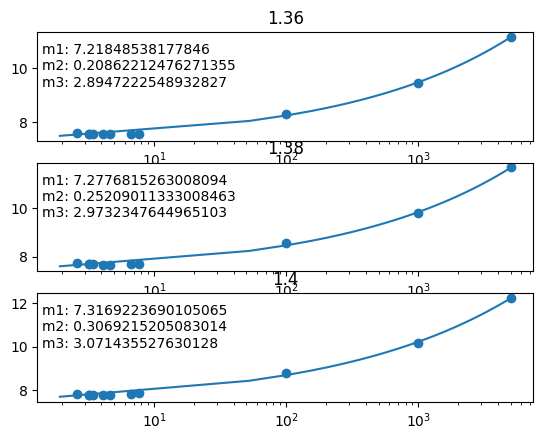

In [14]:
refractive_idxs = [1.36, 1.38, 1.4]

N_vals_interp = np.linspace(N_vals[0] / 4, N_vals[-1], 100)
fig, axs = plt.subplots(len(refractive_idxs), 1)
for i, refractive_idx in enumerate(refractive_idxs):
    m1, m2, m3 = m_params[refractive_idx]
    axs[i].plot(N_vals_interp, m1 + m2*np.exp(np.log(N_vals_interp)/m3))
    axs[i].scatter(N_vals, A_vals[refractive_idx])
    axs[i].set_xscale("log")
    axs[i].set_title(f"{refractive_idx}")
    axs[i].text(0.01, 0.5, f"m1: {m1}\nm2: {m2}\nm3: {m3}", transform=axs[i].transAxes)

plt.show()